<h1 style="font-size: 40px; margin-bottom: 0px;">8.1 Playing with peak data and motif discovery</h1>

<hr style="margin-left: 0px; border: 0.25px solid; border-color: #000000; width: 900px;"></hr>

Today, we'll be switching between Terminal and our Python notebook, but today's lesson will be contained in this file. Last week, we used bowtie2 to align our raw reads to the h19 reference genome. We then took those aligned reads and visualized the aligned reads using IGV. We then used macs2 to identify significant peaks in our taz_1 and taz_2 datasets, and we were able to see how the reads pile up on both sides of the footprint of a DNA binding protein.

First, we will install a program called <a href="http://homer.ucsd.edu/homer/" rel="noopener noreferrer" target="_blank"><u>HOMER (Hypergeometric Optimization of Motif EnRichment)</u></a>, and then we will use it to take a look at the distribution of our reads around our summits. We'll also take a closer look at our peak data by looking at the intersection of our peaks, and taking a look at the concordance of the two TAZ replicates. Even though we can't get IDR on here without running into errors, we can still take a look at how well overlapping peaks match up to one another. To do this, we'll make use of Terminal and Python to play around with our data.

Once we have our merged peaks, we can perform motif discovery on the overlapping peaks to see what are the binding sites recognized by the DNA binding protein(s) that TAZ is interacting with in order to regulate gene expression.

<strong>Learning objectives:</strong>

<ul>
    <li>Learn to install and use simple HOMER functionality</li>
    <li>Learn to plot the peak profile</li>
    <li>Identify overlapping peaks</li>
    <li>Take a basic look at the concordance of the two replicates</li>
    <li>Pull data from peaks ranking high in both replicates</li>
</ul>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

<h1 style="font-size: 40px; margin-bottom: 0px;">Installing HOMER</h1>

<hr style="margin-left: 0px; border: 0.25px solid; border-color: #000000; width: 600px;"></hr>

HOMER is a multifunctional program that can not only perform motif discovery, which is what we'll be primarily using it for, but it also has a lot of next-gen sequencing analysis functionality. For instance, it can also be used to call peaks, much like macs2.

HOMER was primarily developed by Chris Benner at UCSD.

I've placed a <code>configureHomer.pl</code> file in our shared class directory. This file will be used to install the files needed for HOMER to run on your Biology Hub server.

First, you'll want to make a new directory in your home directory that will hold a <u>copy</u> of the <code>configureHomer.pl</code> file.

<h3>Change to home directory</h3>

<pre style="width: 450px; margin-top: 15px; margin-bottom: 15px; color: #000000; background-color: #EEEEEE; border: 1px solid; border-color: #AAAAAA; padding: 10px; border-radius: 15px; font-size: 12px;">cd ~</pre>

<hr style="border: 1px solid; border-color: #BBBBBB;"></hr>

<h3>Make a new directory called <code>homer</code></h3>

<pre style="width: 450px; margin-top: 15px; margin-bottom: 15px; color: #000000; background-color: #EEEEEE; border: 1px solid; border-color: #AAAAAA; padding: 10px; border-radius: 15px; font-size: 12px;">mkdir homer</pre>

<hr style="border: 1px solid; border-color: #BBBBBB;"></hr>

<h3>Copy over <code>configureHomer.pl</code> to your new folder</h3>

<pre style="width: 450px; margin-top: 15px; margin-bottom: 15px; color: #000000; background-color: #EEEEEE; border: 1px solid; border-color: #AAAAAA; padding: 10px; border-radius: 15px; font-size: 12px;">cd homer</pre>

<pre style="width: 450px; margin-top: 15px; margin-bottom: 15px; color: #000000; background-color: #EEEEEE; border: 1px solid; border-color: #AAAAAA; padding: 10px; border-radius: 15px; font-size: 12px;">cp ~/shared/course/mcb201b-shared-readwrite/configureHomer.pl ./</pre>

<hr style="border: 1px solid; border-color: #BBBBBB;"></hr>

Once you've copied over <code>configureHomer.pl</code>, you'll now need to run it in order to install the necessary files.

<h3>Run <code>configureHomer.pl</code></h3>

Since this file uses Perl, another coding language, we will need to run it directly in command line.

<pre style="width: 450px; margin-top: 15px; margin-bottom: 15px; color: #000000; background-color: #EEEEEE; border: 1px solid; border-color: #AAAAAA; padding: 10px; border-radius: 15px; font-size: 12px;">perl configureHomer.pl -install</pre>

You should see that HOMER is now being installed. There might be a few warnings, but there shouldn't be any errors.

<hr style="border: 1px solid; border-color: #BBBBBB;"></hr>

<h3>Update PATH to be able to run HOMER</h3>

We'll need to tell Terminal where to go to find the different files that HOMER uses. This temporarily updates the PATH, but since the server reinitializes things, you'll need to go to your <code>homer</code> directory and re-run this line to update the PATH each time you start up your server.

<pre style="width: 450px; margin-top: 15px; margin-bottom: 15px; color: #000000; background-color: #EEEEEE; border: 1px solid; border-color: #AAAAAA; padding: 10px; border-radius: 15px; font-size: 12px;">PATH=$PATH:/home/jovyan/homer/.//bin/</pre>

<hr style="border: 1px solid; border-color: #BBBBBB;"></hr>

<h3>Install hg19 genome</h3>

Since our alignments were to the hg19 genome, we'll need to install this genome to use with HOMER and then prepare it for use later on when we perform motif discovery. First, let's look at what we currently have installed:

<pre style="width: 450px; margin-top: 15px; margin-bottom: 15px; color: #000000; background-color: #EEEEEE; border: 1px solid; border-color: #AAAAAA; padding: 10px; border-radius: 15px; font-size: 12px;">perl configureHomer.pl -list</pre>

You should see that we don't have the hg19 genome installed, so let's go ahead and install it:

<pre style="width: 450px; margin-top: 15px; margin-bottom: 15px; color: #000000; background-color: #EEEEEE; border: 1px solid; border-color: #AAAAAA; padding: 10px; border-radius: 15px; font-size: 12px;">perl configureHomer.pl -install hg19</pre>

<hr style="border: 1px solid; border-color: #BBBBBB;"></hr>

<h3>Preparse hg19 genome</h3>

Once you've installed the hg19 genome, you'll see a lot of new files under <code>~/homer/data/genomes/h19</code>, and if an analysis requires you to provide an input genome, you can simply specifiy <code>hg19</code>.

Before we can use it though, we'll have to prepare it for use in motif discovery by preparsing the genome.

<pre style="width: 450px; margin-top: 15px; margin-bottom: 15px; color: #000000; background-color: #EEEEEE; border: 1px solid; border-color: #AAAAAA; padding: 10px; border-radius: 15px; font-size: 12px;">preparseGenome.pl hg19 -size 50</pre>

Later on when we perform motif discovery, we can set the size of the region we are analyzing for motifs.

<h1 style="font-size: 40px; margin-bottom: 0px;">Plot peak profile</h1>

<hr style="margin-left: 0px; border: 0.25px solid; border-color: #000000; width: 600px;"></hr>

To get an idea of how all the reads are distributed around their summits, we can plot the peak profile for our two replicates.

<h3>Change directories to prepare to plot peak profiles</h3>

Change your current working directory to this week's directory and make a folder named <code>plot_profile</code>. Set your current working directory to the new folder you created.

<pre style="width: 450px; margin-top: 15px; margin-bottom: 15px; color: #000000; background-color: #EEEEEE; border: 1px solid; border-color: #AAAAAA; padding: 10px; border-radius: 15px; font-size: 12px;">cd ~/MCB201B_F2024/Week_8</pre>

<pre style="width: 450px; margin-top: 15px; margin-bottom: 15px; color: #000000; background-color: #EEEEEE; border: 1px solid; border-color: #AAAAAA; padding: 10px; border-radius: 15px; font-size: 12px;">mkdir plot_profile</pre>

<pre style="width: 450px; margin-top: 15px; margin-bottom: 15px; color: #000000; background-color: #EEEEEE; border: 1px solid; border-color: #AAAAAA; padding: 10px; border-radius: 15px; font-size: 12px;">cd plot_profile</pre>

<hr style="border: 1px solid; border-color: #BBBBBB;"></hr>

<h3>Use annotatePeaks.pl to generate histograms</h3>

HOMER has a program for peak annotation called <code>annotatePeaks.pl</code>, which like the other HOMER functions, you can run directly in Terminal. <a href="http://homer.ucsd.edu/homer/ngs/annotation.html" rel="noopener noreferrer" target="_blank"><u>Documentation for that is here.</u></a>

<code>annotatePeaks.pl</code> is the workhorse of HOMER. It is multifunctional and can be used for a variety of purposes. It's primary purpose is, as it's name implies, to annotate the peaks identified through your peak calling program by identifying nearby genes, distance to the nearest transcription start sites (TSSs), and annotate your peaks with genomic features. It can also be used to generate histograms and heatmaps, which is one of the functions we'll be using it for here.

The syntax to use this program in command line is fairly straightforward; however, there are a number of different options that you can invoke that will change how the program runs, resulting in pretty different outputs.

If we take a look at the documentation to see how we can use this program:

<pre style="width: 450px; margin-top: 15px; margin-bottom: 15px; color: #000000; background-color: #EEEEEE; border: 1px solid; border-color: #AAAAAA; padding: 10px; border-radius: 15px; font-size: 12px;">annotatePeaks.pl &lt;peak file | tss&gt; &lt;genome version&gt; &lbrack;options&rbrack;</pre>

We can either supply it with a peak file, such as our <code>.narrowPeak</code> or <code>*_summit.bed</code> output from macs2. Alternatively, we can specify it to carry out a transcription start site (TSS)-centric analysis, in which case a peak file is not needed. Another way that we can alter how <code>annotatePeaks.pl</code> runs is by supplying it with additional options such as <code>-hist</code>, which will generate a histogram output if we supply it with tag counts in the form of a bedGraph file using the option <code>-bedGraph</code>.

<hr style="border: 1px solid; border-color: #BBBBBB;"></hr>

<h3>Obtain distribution of read counts</h3>

To obtain the distribution of reads around the summit for taz_1, you'll need your <code>10M_taz_1_summits.bed</code> file, as well as the bedgraph file that macs2 output, which contains the distribution of reads across the whole genome.

<pre style="width: 450px; margin-top: 15px; margin-bottom: 15px; color: #000000; background-color: #EEEEEE; border: 1px solid; border-color: #AAAAAA; padding: 10px; border-radius: 15px; font-size: 12px;">annotatePeaks.pl \
~/MCB201B_F2024/Week_7/macs2/10M_taz_1_summits.bed \
hg19 \
-bedGraph ~/MCB201B_F2024/Week_7/macs2/10M_taz_1_treat_pileup.bdg \
-size 2000 \
-hist 10 > 10M_taz_1_summit_profile.txt</pre>

<strong>Let's break down this line of code:</strong>

<code>annotatePeaks.pl</code>

This calls up the annotatePeaks program within HOMER.

<hr style="border: 1px solid; border-color: #AAAAAA;"></hr>

<code>~/MCB201B_F2024/Week_7/macs2/10M_taz_1_summits.bed</code>

Here, we are providing the annotatePeaks program with a bed file containing the coordinates for our peak summits because we're interested in taking a look at the distribution of read counts around our summits. 

<hr style="border: 1px solid; border-color: #AAAAAA;"></hr>

<code>hg19</code>

We specify the reference genome that we want the program to use. We can just provide it with the name of the reference genome <code>hg19</code>, and HOMER will know the directory containing the files for our reference genome that we installed earlier.

<hr style="border: 1px solid; border-color: #AAAAAA;"></hr>

<code>-bedGraph ~/MCB201B_F2024/Week_7/macs2/10M_taz_1_treat_pileup.bdg</code>

While we've provided annotatePeaks with the genomic coordinates to each of our summits, we need to also provide it with information on the read coverage throughout the genome so that it can determine the distribution of reads around our summits. So here, we supply it with the bedGraph file that was generated by macs2, since this file contains information on read coverage for each location in the genome.

<hr style="border: 1px solid; border-color: #AAAAAA;"></hr>

<code>-size 2000</code>

The <code>-size</code> option specifies the size of our region of interest, centered around what we're interested in, which in our case are the peak summits. By specifying a size of 2000, we will be generating a histogram of a region 1kb upstream and downstream of the summit.

<hr style="border: 1px solid; border-color: #AAAAAA;"></hr>

<code>-hist 10</code>

The <code>-hist</code> option changes how annotatePeaks runs. This changes it essentially to "histogram" mode, where it will output (into Terminal) the distribution of read coverage around in our specified region of interest. The argument following the <code>-hist</code> option specifies the bin size for the histogram, so with <code>10</code>, we will be looking at the read distribution in intervals of 10.

<hr style="border: 1px solid; border-color: #AAAAAA;"></hr>

<code>&gt; 10M_taz_1_summit_profile.txt</code>

We want annotatePeaks to save the output into a .txt file rather than dumping it into Terminal, so we redirect the output into <code>taz_1_summit_profile.txt</code>

<h2>Exercise #1: Obtain read count distributions for 10M_taz_2</h2>

For this exercise, see if you can run the <code>annotatePeaks.pl</code> program to generate the histogram for 10M_taz_2.

<h2>Exercise #2: Plot peak profiles for both replicates</h2>

Now, see if you can make use of Python to take the output from HOMER to take a look at how the reads are distributed around the summits for both of our TAZ replicates.

First, import both files into their own pandas DataFrames using the <code>pd.read_csv()</code> function:

```
taz_1_profile = pd.read_csv('~/MCB201B_F2024/Week_8/plot_profile/10M_taz_1_summit_profile.txt',
                            delimiter='\t'
                            )
```

In [2]:
taz_1_profile = pd.read_csv('~/MCB201B_F2024/Week_8/plot_profile/10M_taz_1_summit_profile.txt',
                            delimiter='\t'
                            )

Do the same for taz_2.

In [3]:

taz_2_profile = pd.read_csv('~/MCB201B_F2024/Week_8/plot_profile/10M_taz_2_summit_profile.txt',
                            delimiter='\t'
                            )

Take a look at the first 5 rows.

In [4]:
taz_1_profile.head().style

,Distance from Center (cmd=annotatePeaks.pl /home/jovyan/MCB201B_F2024/Week_7/macs2/10M_taz_1_summits.bed hg19 -bedGraph /home/jovyan/MCB201B_F2024/Week_7/macs2/10M_taz_1_treat_pileup.bdg -size 2000 -hist 10),/home/jovyan/MCB201B_F2024/Week_7/macs2/10M_taz_1_treat_pileup.bdg Coverage,/home/jovyan/MCB201B_F2024/Week_7/macs2/10M_taz_1_treat_pileup.bdg + Tags,/home/jovyan/MCB201B_F2024/Week_7/macs2/10M_taz_1_treat_pileup.bdg - Tags
0,-1000,1.873403,0.475354,0.475168
1,-990,1.881765,0.500302,0.499466
2,-980,1.892683,0.506713,0.505621
3,-970,1.909175,0.524808,0.523159
4,-960,1.930546,0.526016,0.523879


In [5]:
taz_2_profile.head().style

,Distance from Center (cmd=annotatePeaks.pl /home/jovyan/MCB201B_F2024/Week_7/macs2/10M_taz_2_summits.bed hg19 -bedGraph /home/jovyan/MCB201B_F2024/Week_7/macs2/10M_taz_2_treat_pileup.bdg -size 2000 -hist 10),/home/jovyan/MCB201B_F2024/Week_7/macs2/10M_taz_2_treat_pileup.bdg Coverage,/home/jovyan/MCB201B_F2024/Week_7/macs2/10M_taz_2_treat_pileup.bdg + Tags,/home/jovyan/MCB201B_F2024/Week_7/macs2/10M_taz_2_treat_pileup.bdg - Tags
0,-1000,2.307758,0.670165,0.670280
1,-990,2.311751,0.650656,0.650257
2,-980,2.335710,0.705533,0.703137
3,-970,2.349686,0.637792,0.636395
4,-960,2.371649,0.632459,0.630262


You can see that the header is a bit long with a lot of extra information that we don't need for plotting. Replace the headers as follows:

```
taz_1_profile.columns = ['distance_from_center', 'coverage', 'plus_tags', 'minus_tags']
```

Also do the same for taz_2.

In [6]:
taz_1_profile.columns = ['distance_from_center', 'coverage', 'plus_tags', 'minus_tags']
taz_2_profile.columns = ['distance_from_center', 'coverage', 'plus_tags', 'minus_tags']

Take a look to see if the DataFrame updated properly.

In [7]:
taz_1_profile.head().style

,distance_from_center,coverage,plus_tags,minus_tags
0,-1000,1.873403,0.475354,0.475168
1,-990,1.881765,0.500302,0.499466
2,-980,1.892683,0.506713,0.505621
3,-970,1.909175,0.524808,0.523159
4,-960,1.930546,0.526016,0.523879


In [8]:
taz_2_profile.head().style

,distance_from_center,coverage,plus_tags,minus_tags
0,-1000,2.307758,0.670165,0.670280
1,-990,2.311751,0.650656,0.650257
2,-980,2.335710,0.705533,0.703137
3,-970,2.349686,0.637792,0.636395
4,-960,2.371649,0.632459,0.630262


Now plot both profiles on the same subplot as a lineplot with the X-axis as the distance from the center of the summit and the Y-axis as the coverage.

<Axes: xlabel='distance_from_center', ylabel='coverage'>

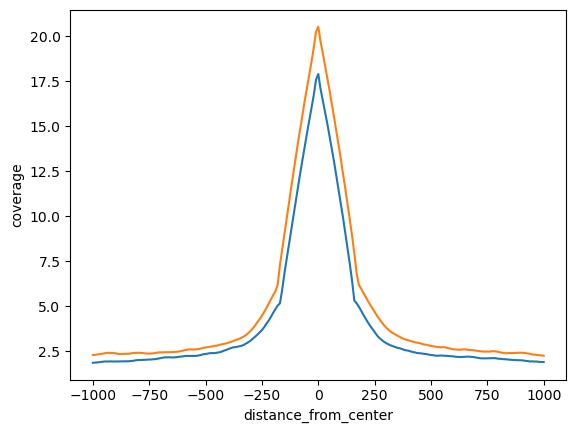

In [9]:
fig, ax = plt.subplots()

sns.lineplot(x=taz_1_profile['distance_from_center'],
             y=taz_1_profile['coverage']
            )

sns.lineplot(x=taz_2_profile['distance_from_center'],
             y=taz_2_profile['coverage']
            )


You can see in your plot that while the coverage pattern is similar between the two replicates, they vary slightly in their read depth, with taz_2 having overall higher coverage than taz_1. This is normally expected, since each replicate will have slightly different read counts. The important consideration is that the plot profiles look similar in their shape.

<h1 style="font-size: 40px; margin-bottom: 0px;">Plot TSS-centric read distribution</h1>

<hr style="margin-left: 0px; border: 0.25px solid; border-color: #000000; width: 600px;"></hr>

The multifunctionality of <code>annotatePeaks.pl</code> means that we can also perform a TSS-centric analysis. In this case, we can supply the program with the <code>tss</code> argument along with our bedGraph files, so it can provide us with the distribution of reads around TSSs. This can help give us an idea into if our protein of interest is regulating its target genes via promoter binding or through more distant interactions.

<h3>Make directory to prepare to obtain read distribution around TSS</h3>

<pre style="width: 450px; margin-top: 15px; margin-bottom: 15px; color: #000000; background-color: #EEEEEE; border: 1px solid; border-color: #AAAAAA; padding: 10px; border-radius: 15px; font-size: 12px;">mkdir tss_profile</pre>

<hr style="border: 1px solid; border-color: #BBBBBB;"></hr>

<h3>Change to new directory</h3>

<pre style="width: 450px; margin-top: 15px; margin-bottom: 15px; color: #000000; background-color: #EEEEEE; border: 1px solid; border-color: #AAAAAA; padding: 10px; border-radius: 15px; font-size: 12px;">cd tss_profile</pre>

<hr style="border: 1px solid; border-color: #BBBBBB;"></hr>

<h3>Obtain read distributions around TSS for 10M_taz_1</h3>

<pre style="width: 450px; margin-top: 15px; margin-bottom: 15px; color: #000000; background-color: #EEEEEE; border: 1px solid; border-color: #AAAAAA; padding: 10px; border-radius: 15px; font-size: 12px;">annotatePeaks.pl \
tss \
hg19 \
-bedGraph ~/MCB201B_F2024/Week_7/macs2/10M_taz_1_treat_pileup.bdg \
-size 8000 \
-hist 10 \
> 10M_taz_1_tss_profile.txt</pre>

Here, we make minor alterations to how we ran the annotatePeaks program to instruct it to focus on TSSs and to provide a larger region of interest. So we provide the <code>tss</code> argument and increase the <code>-size</code> to <code>8000</code>. That way, we'll get an output containing the read distribution centered around TSSs, which we can plot like we did with the summit profile.

<h2>Exercise #3: Plot TSS read distribution</h2>

For this exercise, see if you can plot the read distribution around TSSs for both your 10M_taz_1 and 10M_taz_2 outputs.

First, import your files:

In [10]:
taz_1_tss_profile = pd.read_csv('~/MCB201B_F2024/Week_8/tss_profile/10M_taz_1_tss_profile.txt',
                            delimiter='\t'
                            )
taz_2_tss_profile = pd.read_csv('~/MCB201B_F2024/Week_8/tss_profile/10M_taz_2_tss_profile.txt',
                            delimiter='\t'
                            )

taz_1_tss_profile.head().style

,Distance from Center (cmd=annotatePeaks.pl tss hg19 -bedGraph /home/jovyan/MCB201B_F2024/Week_7/macs2/10M_taz_1_treat_pileup.bdg -size 8000 -hist 10),/home/jovyan/MCB201B_F2024/Week_7/macs2/10M_taz_1_treat_pileup.bdg Coverage,/home/jovyan/MCB201B_F2024/Week_7/macs2/10M_taz_1_treat_pileup.bdg + Tags,/home/jovyan/MCB201B_F2024/Week_7/macs2/10M_taz_1_treat_pileup.bdg - Tags
0,-4000,0.588917,0.014113,0.014380
1,-3990,0.591411,0.012937,0.012688
2,-3980,0.592038,0.013916,0.013854
3,-3970,0.594470,0.014405,0.014162
4,-3960,0.593622,0.014789,0.014873


Update the column headers for convenience:

In [11]:
taz_1_tss_profile.columns = ['distance_from_center', 'coverage', 'plus_tags', 'minus_tags']
taz_2_tss_profile.columns = ['distance_from_center', 'coverage', 'plus_tags', 'minus_tags']

In [12]:
taz_1_tss_profile.head().style

,distance_from_center,coverage,plus_tags,minus_tags
0,-4000,0.588917,0.014113,0.014380
1,-3990,0.591411,0.012937,0.012688
2,-3980,0.592038,0.013916,0.013854
3,-3970,0.594470,0.014405,0.014162
4,-3960,0.593622,0.014789,0.014873


Plot the distributions:

(0.0, 20.0)

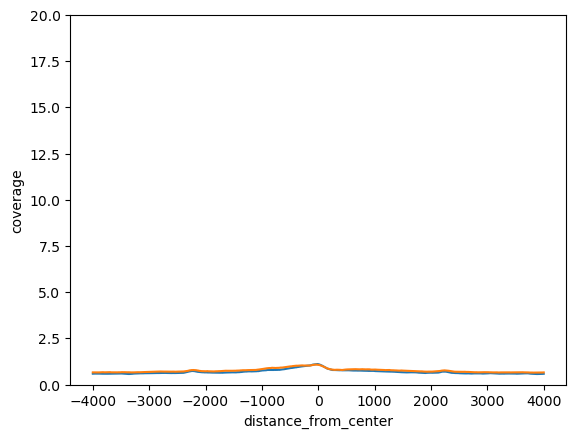

In [13]:
fig, ax = plt.subplots()

sns.lineplot(x=taz_1_tss_profile['distance_from_center'],
             y=taz_1_tss_profile['coverage']
            )

sns.lineplot(x=taz_2_tss_profile['distance_from_center'],
             y=taz_2_tss_profile['coverage']
            )

plt.ylim(0, 20)

What does the distribution tell us about the way that TAZ (and its associated DNA-binding protein) is potentially regulating gene transcription?

<h1 style="font-size: 40px; margin-bottom: 0px;">Determine distance from TSS</h1>

<hr style="margin-left: 0px; border: 0.25px solid; border-color: #000000; width: 600px;"></hr>

The results that we get when we look at the read distributions around TSSs seem to suggest that our peaks may be more distant than &pm;4kbp. What we can then do is take a look at the distribution of distances that our peaks are located from their nearest TSS. That can help give us a little bit more insight into our above result.

We'll once again make use of <code>annotatePeaks.pl</code> with slight modifications. If we take a look at <a href="http://homer.ucsd.edu/homer/ngs/annotation.html" rel="noopener noreferrer" target="_blank"><u>the documentation for annotatePeaks</u></a>, among one of the outputs for its basic annotate function is a column containing information on the distance to the nearest TSS, which is what we're interested in.

So we can use the basic annotate function of <code>annotatePeaks.pl</code> and focus on TSS annotations.

<h3>Create new directory <code>annotation</code></h3>

<pre style="width: 450px; margin-top: 15px; margin-bottom: 15px; color: #000000; background-color: #EEEEEE; border: 1px solid; border-color: #AAAAAA; padding: 10px; border-radius: 15px; font-size: 12px;">mkdir annotation</pre>

Make sure that you are making your <code>annotation</code> folder in this week's directory.

<hr style="border: 1px solid; border-color: #BBBBBB;"></hr>

<h3>Change to new directory</h3>

<pre style="width: 450px; margin-top: 15px; margin-bottom: 15px; color: #000000; background-color: #EEEEEE; border: 1px solid; border-color: #AAAAAA; padding: 10px; border-radius: 15px; font-size: 12px;">cd annotation</pre>

<hr style="border: 1px solid; border-color: #BBBBBB;"></hr>

<h3>Annotate to find distance to nearest TSS for 10M_taz_1</h3>

<pre style="width: 450px; margin-top: 15px; margin-bottom: 15px; color: #000000; background-color: #EEEEEE; border: 1px solid; border-color: #AAAAAA; padding: 10px; border-radius: 15px; font-size: 12px;">annotatePeaks.pl \
~/MCB201B_F2024/Week_7/macs2/10M_taz_1_peaks.narrowPeak \
hg19 \
-noann \
> 10M_taz_1_annotation.txt</pre>

<strong>Let's break down this code:</code>

<code>annotatePeaks.pl</code>

This calls up the annotatePeaks program.

<hr style="border: 1px solid; border-color: #AAAAAA;"></hr>

<code>~/MCB201B_F2024/Week_7/macs2/10M_taz_1_peaks.narrowPeak</code>

Here, we provide our peak file that contains the peaks and their chromosomal coordinates that we want to annotate.

<hr style="border: 1px solid; border-color: #AAAAAA;"></hr>

<code>hg19</code>

We indicate that we want to use the hg19 reference genome, which we have installed.

<hr style="border: 1px solid; border-color: #AAAAAA;"></hr>

<code>-noann</code>

This option alters how the annotatePeaks program runs. By default the program will mark peak locations based on the genomic feature in which its located (intron, exon, TSS, CDS, etc), and the program will also identify the nearest gene and TSS. By providing the <code>-noann</code>, we are instructing the annotatePeaks program not to annotate peaks for genomic features, and instead, just focus on identifying nearby genes and TSSs. 

<hr style="border: 1px solid; border-color: #AAAAAA;"></hr>

<code>&gt; 10M_taz_1_annotation.txt</code>

We redirect the output data into a .txt file that we can then load into Python in order to pull relevant information.

<h2>Exercise #4: Annotate 10M_taz_2 as well</h2>

Now get the annotations for 10M_taz_2 as well.

<h2>Exercise #5: Create barplot of peak distance to TSS</h2>

For this exercise, you'll need to first import your annotated peaks as a DataFrame, like we've done before:

In [14]:
taz_1_annotation = pd.read_csv('~/MCB201B_F2024/Week_8/annotation/10M_taz_1_annotation.txt',
                            delimiter='\t'
                            )
taz_2_annotation = pd.read_csv('~/MCB201B_F2024/Week_8/annotation/10M_taz_2_annotation.txt',
                            delimiter='\t'
                            )

Take a quick look at the first five rows of one of the DataFrames:

In [15]:
taz_1_annotation.head().style

,PeakID (cmd=annotatePeaks.pl /home/jovyan/MCB201B_F2024/Week_7/macs2/10M_taz_1_peaks.narrowPeak hg19 -noann),Chr,Start,End,Strand,Peak Score,Focus Ratio/Region Size,Annotation,Detailed Annotation,Distance to TSS,Nearest PromoterID,Entrez ID,Nearest Unigene,Nearest Refseq,Nearest Ensembl,Gene Name,Gene Alias,Gene Description,Gene Type
0,10M_taz_1_peak_1347,chr14,62221781,62222474,+,2703,nan,nan,nan,-4312.000000,NR_144368,105370526.000000,nan,NR_144368,ENSG00000258667,HIF1A-AS3,HIFAL,HIF1A antisense RNA 3,ncRNA
1,10M_taz_1_peak_1912,chr19,1383199,1383934,+,2081,nan,nan,nan,-340.000000,NM_024407,374291.000000,nan,NM_024407,ENSG00000115286,NDUFS7,CI-20|CI-20KD|MC1DN3|MY017|PSST,NADH:ubiquinone oxidoreductase core subunit S7,protein-coding
2,10M_taz_1_peak_31,chr1,19378871,19379364,+,1702,nan,nan,nan,-95947.000000,NM_001136265,126917.000000,nan,NM_001136265,ENSG00000169991,IFFO2,-,intermediate filament family orphan 2,protein-coding
3,10M_taz_1_peak_1768,chr17,73030385,73031437,+,1558,nan,nan,nan,2245.000000,NR_110835,23510.000000,nan,NM_015353,ENSG00000180901,KCTD2,-,potassium channel tetramerization domain containing 2,protein-coding
4,10M_taz_1_peak_278,chr1,161369269,161369922,+,1535,nan,nan,nan,-31929.000000,NM_001013625,257177.000000,nan,NM_001013625,ENSG00000188931,CFAP126,C1orf192|Flattop|Fltp,cilia and flagella associated protein 126,protein-coding


You can see that the first column header is pretty long. If you want, you can go ahead and rename just that one column header:

```
taz_1_annotation = taz_1_annotation.rename(columns={'PeakID (cmd=annotatePeaks.pl /home/jovyan/MCB201B_F2024/Week_7/macs2/10M_taz_1_peaks.narrowPeak hg19 -noann)': 'PeakID'})
```

If your column header is different than what is shown here, you'll need to replace what the example shows with your exact column header. Otherwise, it won't properly replace the header name.

You can also update the other DataFrame as well.

<a href="https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.rename.html" rel="noopener noreferrer" target="_blank"><u>Documentation for <code>pd.DataFrame.rename()</code> is here.</u></a>

In [16]:
taz_1_annotation = taz_1_annotation.rename(columns={'PeakID (cmd=annotatePeaks.pl /home/jovyan/MCB201B_F2024/Week_7/macs2/10M_taz_1_peaks.narrowPeak hg19 -noann)': 'PeakID'})
taz_2_annotation = taz_2_annotation.rename(columns={'PeakID (cmd=annotatePeaks.pl /home/jovyan/MCB201B_F2024/Week_7/macs2/10M_taz_2_peaks.narrowPeak hg19 -noann)': 'PeakID'})

taz_2_annotation.head().style

,PeakID,Chr,Start,End,Strand,Peak Score,Focus Ratio/Region Size,Annotation,Detailed Annotation,Distance to TSS,Nearest PromoterID,Entrez ID,Nearest Unigene,Nearest Refseq,Nearest Ensembl,Gene Name,Gene Alias,Gene Description,Gene Type
0,10M_taz_2_peak_1145,chr14,62221709,62222529,+,3466,nan,nan,nan,-4304.000000,NR_144368,105370526.000000,nan,NR_144368,ENSG00000258667,HIF1A-AS3,HIFAL,HIF1A antisense RNA 3,ncRNA
1,10M_taz_2_peak_1603,chr19,1383159,1383910,+,1945,nan,nan,nan,-372.000000,NM_024407,374291.000000,nan,NM_024407,ENSG00000115286,NDUFS7,CI-20|CI-20KD|MC1DN3|MY017|PSST,NADH:ubiquinone oxidoreductase core subunit S7,protein-coding
2,10M_taz_2_peak_712,chr11,59317975,59319443,+,1905,nan,nan,nan,36323.000000,NM_001004711,390199.000000,nan,NM_001004711,ENSG00000172742,OR4D9,OR11-253,olfactory receptor family 4 subfamily D member 9,protein-coding
3,10M_taz_2_peak_3458,chr9,137029377,137030049,+,1828,nan,nan,nan,-27.000000,NR_023344,100151684.000000,nan,NR_023344,ENSG00000221676,RNU6ATAC,RNU6ATAC1|U6ATAC,"RNA, U6atac small nuclear",snRNA
4,10M_taz_2_peak_1428,chr17,37309742,37311103,+,1781,nan,nan,nan,-2532.000000,NM_020405,57125.000000,nan,NM_020405,ENSG00000161381,PLXDC1,TEM3|TEM7,plexin domain containing 1,protein-coding


You can see in the <code>Distance to TSS</code> column that the values are both positive and negative depending on whether or not the peaks are downstream or upstream to the TSS.

We only really care about the absolute distance for our barplots, so we can take the absolute value of the distances using <code>np.abs()</code>. Use this function to pull just the absolute values of the distances to a TSS. <a href="https://numpy.org/doc/2.0/reference/generated/numpy.absolute.html" rel="noopener noreferrer" target="_blank"><u>Documentation for <code>np.abs()</code> is here</u></a>.

In [17]:
taz_1_annotation['Distance to TSS']

taz_1_annotation_abs = np.abs(taz_1_annotation['Distance to TSS'])
taz_2_annotation_abs = np.abs(taz_2_annotation['Distance to TSS'])

print(taz_1_annotation_abs)
print(taz_2_annotation_abs)

0         4312.0
1          340.0
2        95947.0
3         2245.0
4        31929.0
          ...   
4300    371000.0
4301      3153.0
4302       489.0
4303     47703.0
4304    469714.0
Name: Distance to TSS, Length: 4305, dtype: float64
0         4304.0
1          372.0
2        36323.0
3           27.0
4         2532.0
          ...   
3501       877.0
3502     18584.0
3503    545635.0
3504     91796.0
3505      9647.0
Name: Distance to TSS, Length: 3506, dtype: float64


Now convert the values to kilobases:

In [18]:
taz_1_annotation_abs_kb = taz_1_annotation_abs.div(1000)
taz_2_annotation_abs_kb = taz_2_annotation_abs.div(1000)

print(taz_1_annotation_abs_kb)

0         4.312
1         0.340
2        95.947
3         2.245
4        31.929
         ...   
4300    371.000
4301      3.153
4302      0.489
4303     47.703
4304    469.714
Name: Distance to TSS, Length: 4305, dtype: float64


Here, I have set up a list of bin ranges for you to use for counting how many values are in each bin. Run the code cell to save the objects to the variable <code>distances</code>.

In [19]:
distances = [[0, 0.999], [1, 9.999], [10, 99.999], [100, np.inf]]

If we want to count the value for a single bin, we can make use of the function <code>pd.Series.value_counts()</code> to obtain a count of all the values in our Series that fall within the indicated range.

```
print(abs_t1_kb.value_counts(bins=[0,0.999]))
```

In [20]:
print(taz_1_annotation_abs_kb.value_counts(bins=[0,0.999]))

(-0.001, 0.999]    302
Name: Distance to TSS, dtype: int64


This comes with extra information that we don't need, so we can use the <code>pd.Series.item()</code> to return just the counts and not the extra information.

<a href="https://pandas.pydata.org/docs/reference/api/pandas.Series.item.html" rel="noopener noreferrer" target="_blank"><u>Documentation for <code>pd.Series.item()</code> is here.</u></a>

```
print(abs_t1_kb.value_counts(bins=[0,0.999]).item())
```

In [21]:
print(taz_1_annotation_abs_kb.value_counts(bins=[0,0.999]).item())

302


Now set up a for loop that makes use of <code>pd.Series.value_counts().item()</code> to obtain a list of counts for each bin range in <code>distances</code>.

In [22]:
taz1_counts = []
taz2_counts = []

for i in distances:
    taz1_counts.append(taz_1_annotation_abs_kb.value_counts(bins=i).item())
    taz2_counts.append(taz_2_annotation_abs_kb.value_counts(bins=i).item())

taz2_counts

[242, 659, 1974, 629]

Convert the counts to a percent of the total counts for each replicate.

In [23]:
percent_taz1_counts = (taz1_counts/np.sum(taz1_counts))*100
percent_taz2_counts = (taz2_counts/np.sum(taz2_counts))*100

print(percent_taz1_counts)

[ 7.01835928 19.21914943 54.93841506 18.82407623]


Plot a barplot of the counts.

Text(0, 0.5, 'Percent of total peaks')

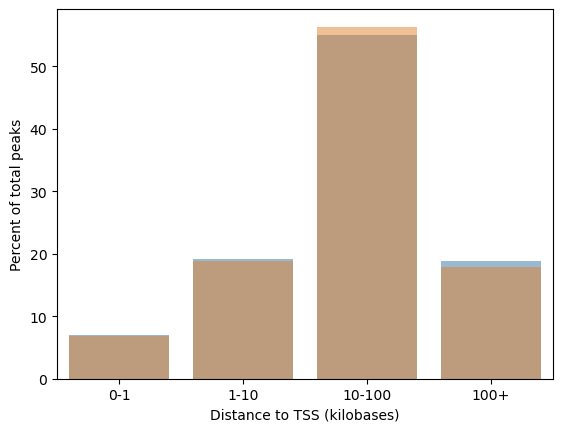

In [24]:
fig, ax = plt.subplots()

sns.barplot(percent_taz1_counts, alpha=0.5)
sns.barplot(percent_taz2_counts, alpha=0.5)

ax.set_xticks([0,1,2,3], ['0-1', '1-10', '10-100', '100+'])
plt.xlabel('Distance to TSS (kilobases)')
plt.ylabel('Percent of total peaks')

What do the distribution of peak distances to TSS suggest to us about how TAZ is regulating gene expression?

<h1 style="font-size: 40px; margin-bottom: 0px;">Find concordant peaks between two replicates</h1>

<hr style="margin-left: 0px; border: 0.25px solid; border-color: #000000; width: 900px;"></hr>

Currently, we have two replicates with thousands of identified peaks that were found to be significant compared to the background levels (using our pooled IgG sequencing data). However, not all those peaks will be the same between replicates, due to biological and experimental variability, so we'll want to focus on just those peaks that are present in both our replicates for a more focused downstream analysis.

<h2>HOMER's mergePeaks program</h2>

To find peaks that are shared between our two replicates, we will make use of the <code>mergePeaks</code> program, and we'll provide it with the .narrowPeak files for both our replicates for analysis.

<a href="http://homer.ucsd.edu/homer/ngs/mergePeaks.html" rel="noopener noreferrer" target="_blank"><u>Documentation for the <code>mergePeaks</code> utility is here.</u></a>

If we take a look at the command line structure to use this program to pull overlapping peaks:

<pre style="width: 750px; margin-top: 15px; margin-bottom: 15px; color: #000000; background-color: #EEEEEE; border: 1px solid; border-color: #AAAAAA; padding: 10px; border-radius: 15px; font-size: 12px;">mergePeaks -d &lt;max distance to merge&gt; &lt;peak file 1&gt; &lt;peak file 2&gt; &lbrack;peak file N&rbrack; &lbrack;options&rbrack; -prefix &lt;base name&gt;</pre>

<h3>Create <code>merged</code> directory and enter it</h3>

<pre style="width: 450px; margin-top: 15px; margin-bottom: 15px; color: #000000; background-color: #EEEEEE; border: 1px solid; border-color: #AAAAAA; padding: 10px; border-radius: 15px; font-size: 12px;">mkdir merged</pre>

Make sure that you are making your <code>merged</code> folder in this week's directory.

<pre style="width: 450px; margin-top: 15px; margin-bottom: 15px; color: #000000; background-color: #EEEEEE; border: 1px solid; border-color: #AAAAAA; padding: 10px; border-radius: 15px; font-size: 12px;">cd merged</pre>

<hr style="border: 1px solid; border-color: #BBBBBB;"></hr>

<h3>Find overlapping peaks and unique peaks</h3>

<pre style="width: 450px; margin-top: 15px; margin-bottom: 15px; color: #000000; background-color: #EEEEEE; border: 1px solid; border-color: #AAAAAA; padding: 10px; border-radius: 15px; font-size: 12px;">mergePeaks \
-d 100 \
~/MCB201B_F2024/Week_7/macs2/10M_taz_1_peaks.narrowPeak \
~/MCB201B_F2024/Week_7/macs2/10M_taz_2_peaks.narrowPeak \
-prefix merged</pre>

<strong>Let's break down the code:</strong>

<code>mergePeaks</code>

Here, we are calling up the mergePeaks program.

<hr style="border: 1px solid; border-color: #AAAAAA;"></hr>

<code>-d 100</code>

Here, we provide the program with the maximum distance that we would like it to merge peaks based on the distance between the peak centers. So peaks whose centers are greater than 100bp apart will not be considered overlapping.

<hr style="border: 1px solid; border-color: #AAAAAA;"></hr>

<code>~/MCB201B_F2024/Week_7/macs2/10M_taz_1_peaks.narrowPeak</code>

The .narrowPeak file corresponding to our first replicate that we want it to pull peak information from.

<hr style="border: 1px solid; border-color: #AAAAAA;"></hr>

<code>~/MCB201B_F2024/Week_7/macs2/10M_taz_1_peaks.narrowPeak</code>

The .narrowPeak file corresponding to our second replicate. mergePeaks will identify the overlapping peaks from the two files we supply it. We can also supply it with additional files, and it will analyze all of them.

<hr style="border: 1px solid; border-color: #AAAAAA;"></hr>

<code>-prefix merged</code>

Here, we supply it with the basename that we want it to add to all the files that it outputs. Based on how we set up the command, we will have three output files, two that correspond to unique peaks present in their respective replicates and one that contains the information on overlapping peaks, which is the file that we're most interested in.

<h3>Simplify output file names</h3>

If you take a look in your File Browser, you can see the three outputs, and they have rather long, unwieldy names, especially the file containing our overlapping peaks. So let's just directly in the File Browser rename the files for simplicity's sake.

Rename the file containing the overlapping peaks to: <code>merged_taz_peaks.narrowPeak</code>

<hr style="border: 1px solid; border-color: #BBBBBB;"></hr>

<h2>Import <code>merged_taz_peaks.narrowPeak</code> as a DataFrame</h2>

Now let's take a look at the information contained within the file by importing into our Python notebook.

First, import the .narrowPeak file using <code>pd.read_csv()</code> like we've done earlier.

In [25]:
merged_peaks = pd.read_csv('~/MCB201B_F2024/Week_8/merged/merged_taz_peaks.narrowPeak',
                            delimiter='\t'
                            )

Now let's look at the first five rows to check if it imported okay.

In [26]:
merged_peaks.head().style

,#name (cmd = mergePeaks -d 100 /home/jovyan/MCB201B_F2024/Week_7/macs2/10M_taz_1_peaks.narrowPeak /home/jovyan/MCB201B_F2024/Week_7/macs2/10M_taz_2_peaks.narrowPeak -prefix merged),chr,start,end,strand,Stat,Parent files,Total subpeaks,/home/jovyan/MCB201B_F2024/Week_7/macs2/10M_taz_1_peaks.narrowPeak,/home/jovyan/MCB201B_F2024/Week_7/macs2/10M_taz_2_peaks.narrowPeak
0,Merged-chr20-32497481-2,chr20,32497405,32497557,+,0.000000,/home/jovyan/MCB201B_F2024/Week_7/macs2/10M_taz_1_peaks.narrowPeak|/home/jovyan/MCB201B_F2024/Week_7/macs2/10M_taz_2_peaks.narrowPeak,2,10M_taz_1_peak_2400,10M_taz_2_peak_1962
1,Merged-chr20-32978672-2,chr20,32978614,32978730,+,0.000000,/home/jovyan/MCB201B_F2024/Week_7/macs2/10M_taz_1_peaks.narrowPeak|/home/jovyan/MCB201B_F2024/Week_7/macs2/10M_taz_2_peaks.narrowPeak,2,10M_taz_1_peak_2401,10M_taz_2_peak_1963
2,Merged-chr20-33113793-2,chr20,33113732,33113855,+,0.000000,/home/jovyan/MCB201B_F2024/Week_7/macs2/10M_taz_1_peaks.narrowPeak|/home/jovyan/MCB201B_F2024/Week_7/macs2/10M_taz_2_peaks.narrowPeak,2,10M_taz_1_peak_2402,10M_taz_2_peak_1964
3,Merged-chr20-33640689-2,chr20,33640631,33640748,+,0.000000,/home/jovyan/MCB201B_F2024/Week_7/macs2/10M_taz_1_peaks.narrowPeak|/home/jovyan/MCB201B_F2024/Week_7/macs2/10M_taz_2_peaks.narrowPeak,2,10M_taz_1_peak_2403,10M_taz_2_peak_1965
4,Merged-chr20-33803296-2,chr20,33803233,33803360,+,0.000000,/home/jovyan/MCB201B_F2024/Week_7/macs2/10M_taz_1_peaks.narrowPeak|/home/jovyan/MCB201B_F2024/Week_7/macs2/10M_taz_2_peaks.narrowPeak,2,10M_taz_1_peak_2404,10M_taz_2_peak_1966


So we can see that the column headers are a bit long, so we can shorten things for our sake later on by using the <code>pd.DataFrame.rename()</code> function.

In [27]:
merged_peaks = merged_peaks.rename(columns={'#name (cmd = mergePeaks -d 100 /home/jovyan/MCB201B_F2024/Week_7/macs2/10M_taz_1_peaks.narrowPeak /home/jovyan/MCB201B_F2024/Week_7/macs2/10M_taz_2_peaks.narrowPeak -prefix merged)':'name',
                                            '/home/jovyan/MCB201B_F2024/Week_7/macs2/10M_taz_1_peaks.narrowPeak':'taz_1',
                                            '/home/jovyan/MCB201B_F2024/Week_7/macs2/10M_taz_2_peaks.narrowPeak':'taz_2'})

And let's check to see if it updated properly:

In [28]:
merged_peaks.head().style

,name,chr,start,end,strand,Stat,Parent files,Total subpeaks,taz_1,taz_2
0,Merged-chr20-32497481-2,chr20,32497405,32497557,+,0.000000,/home/jovyan/MCB201B_F2024/Week_7/macs2/10M_taz_1_peaks.narrowPeak|/home/jovyan/MCB201B_F2024/Week_7/macs2/10M_taz_2_peaks.narrowPeak,2,10M_taz_1_peak_2400,10M_taz_2_peak_1962
1,Merged-chr20-32978672-2,chr20,32978614,32978730,+,0.000000,/home/jovyan/MCB201B_F2024/Week_7/macs2/10M_taz_1_peaks.narrowPeak|/home/jovyan/MCB201B_F2024/Week_7/macs2/10M_taz_2_peaks.narrowPeak,2,10M_taz_1_peak_2401,10M_taz_2_peak_1963
2,Merged-chr20-33113793-2,chr20,33113732,33113855,+,0.000000,/home/jovyan/MCB201B_F2024/Week_7/macs2/10M_taz_1_peaks.narrowPeak|/home/jovyan/MCB201B_F2024/Week_7/macs2/10M_taz_2_peaks.narrowPeak,2,10M_taz_1_peak_2402,10M_taz_2_peak_1964
3,Merged-chr20-33640689-2,chr20,33640631,33640748,+,0.000000,/home/jovyan/MCB201B_F2024/Week_7/macs2/10M_taz_1_peaks.narrowPeak|/home/jovyan/MCB201B_F2024/Week_7/macs2/10M_taz_2_peaks.narrowPeak,2,10M_taz_1_peak_2403,10M_taz_2_peak_1965
4,Merged-chr20-33803296-2,chr20,33803233,33803360,+,0.000000,/home/jovyan/MCB201B_F2024/Week_7/macs2/10M_taz_1_peaks.narrowPeak|/home/jovyan/MCB201B_F2024/Week_7/macs2/10M_taz_2_peaks.narrowPeak,2,10M_taz_1_peak_2404,10M_taz_2_peak_1966


Now that we have our overlapping peaks, it's not enough to just know which peaks are shared between our two replicates. We also need to know how reproducible these peaks are between our two replicates.

<h2>Assessing reproducibility</h2>

Dr. Ingolia mentioned in lecture that between replicates, there is variability in which peaks are called as well as their significance, which can be due to normal biological or experimental variability. <a href="https://doi.org/10.1101/gr.136184.111" rel="noopener noreferrer" target="_blank"><u>The standard way (set by the ENCODE and modeENCODE consortia)</u></a> of determining if the peaks that we identify through our peak calling program is to calculate the Irreproducible Discovery Rate (IDR), developed by <a href="https://doi.org/10.1214/11-AOAS466" rel="noopener noreferrer" target="_blank"><u>Li et al 2011</u></a>. 

The IDR framework allows for us to determine the reproducibility of our peaks (or in general the findings of high-throughput experiments) by comparing replicates to one another. IDR provides us with a quantitative assessment of when two replicates are no longer consistent with one another, which could point to findings that are less reproducible. In our case, that would suggest that those peaks may not necessarily be reproducible in repeated experiments. It's in a way conceptually similar to the FDR, where a lower IDR indicates a lower chance that the peak is irreproducible.

Unfortunately, there's not a good way to get the <a href="https://github.com/kundajelab/idr" rel="noopener noreferrer" target="_blank"><u>IDR package</u></a> onto our servers without running into errors, so we'll be taking a qualitative look at the concordance of our data, which will give us a qualitative idea of which peaks are probably more consistent between our replicates. And then we'll use those peaks for motif discovery.

To do this, we'll first need our original .narrowPeak files, so that we can rank the peaks according to their significance (-log10(qvalue)). Then we can used our <code>merged_taz_peaks.narrowPeak</code> file containing our overlapping peaks to pull all the information only for the overlapping peaks. And then we can plot the two replicates against one another to see how correlated the ranks are for each of the overlapping peaks. We can also do the same for the significance of each overlapping peak.

<h2>Exercise #5: Import our original peak.xls files</h2>

Let's import our original .xls file that was output by macs2, so we have all the information for each peak.

```
taz_1 = pd.read_csv('~/MCB201B_F2024/Week_7/macs2/10M_taz_1_peaks.xls', 
                    delimiter='\t', 
                    comment='#'
                   )
```

And do the same for taz_2.

In [29]:
taz_1 = pd.read_csv('~/MCB201B_F2024/Week_7/macs2/10M_taz_1_peaks.xls', 
                    delimiter='\t', 
                    comment='#'
                   )
taz_2 = pd.read_csv('~/MCB201B_F2024/Week_7/macs2/10M_taz_2_peaks.xls', 
                    delimiter='\t', 
                    comment='#'
                   )


Let's check to see how the file imported.

In [30]:
taz_1.head().style

,chr,start,end,length,abs_summit,pileup,-log10(pvalue),fold_enrichment,-log10(qvalue),name
0,chr1,960117,960354,238,960224,16,17.881900,10.236800,13.587900,10M_taz_1_peak_1
1,chr1,1200310,1200494,185,1200445,12,13.121100,8.237770,9.040820,10M_taz_1_peak_2
2,chr1,1296015,1296286,272,1296163,14,16.208900,9.663280,11.979200,10M_taz_1_peak_3
3,chr1,1310545,1310710,166,1310679,7,6.880840,5.153750,3.250230,10M_taz_1_peak_4
4,chr1,1617792,1617964,173,1617919,7,4.929440,3.961240,1.578600,10M_taz_1_peak_5


In [31]:
taz_2.head().style

,chr,start,end,length,abs_summit,pileup,-log10(pvalue),fold_enrichment,-log10(qvalue),name
0,chr1,960071,960340,270,960190,18,19.146600,10.490600,14.832300,10M_taz_2_peak_1
1,chr1,1200204,1200501,298,1200378,10,7.942810,5.465390,4.214470,10M_taz_2_peak_2
2,chr1,1295982,1296211,230,1296132,14,15.660100,9.359180,11.472500,10M_taz_2_peak_3
3,chr1,1992808,1993144,337,1992934,20,20.012900,10.433900,15.670300,10M_taz_2_peak_4
4,chr1,6784654,6784910,257,6784764,15,16.779000,9.810590,12.550400,10M_taz_2_peak_5


<h2>Exercise #6: Sort DataFrames according to the <code>-log10(qvalue)</code></h2>

Now, we'll want to rank all the peaks according to their significance, with the greatest -log10(qvalue) having the assigned rank of 1.

First, sort both your DataFrames by the <code>-log10(qvalue)</code>

In [32]:
taz_1_sorted = taz_1.sort_values(by='-log10(qvalue)', ascending=False)
taz_2_sorted = taz_2.sort_values(by='-log10(qvalue)', ascending=False)

taz_1_sorted.head().style

,chr,start,end,length,abs_summit,pileup,-log10(pvalue),fold_enrichment,-log10(qvalue),name
1346,chr14,62221781,62222474,694,62222163,225,277.789000,37.062200,270.377000,10M_taz_1_peak_1347
1911,chr19,1383199,1383934,736,1383513,163,215.209000,40.406900,208.115000,10M_taz_1_peak_1912
30,chr1,19378871,19379364,494,19379131,96,177.232000,62.489200,170.289000,10M_taz_1_peak_31
1767,chr17,73030385,73031437,1053,73030628,126,162.733000,35.672800,155.876000,10M_taz_1_peak_1768
277,chr1,161369269,161369922,654,161369601,110,160.424000,43.884700,153.591000,10M_taz_1_peak_278


<h2>Exercise #7: Assign ranks</code></h2>

Give all the peaks a rank by creating a new column called <code>rank</code> and supplying it with a list of ascending numbers.

In [33]:
taz_1_sorted['rank'] = np.arange(1, len(taz_1_sorted['-log10(qvalue)']) + 1, 1)
taz_2_sorted['rank'] = np.arange(1, len(taz_2_sorted['-log10(qvalue)']) + 1, 1)

Do a quick check of both ends of the DataFrame to make sure ranks were properly assigned.

In [34]:
taz_1_sorted.head().style

,chr,start,end,length,abs_summit,pileup,-log10(pvalue),fold_enrichment,-log10(qvalue),name,rank
1346,chr14,62221781,62222474,694,62222163,225,277.789000,37.062200,270.377000,10M_taz_1_peak_1347,1
1911,chr19,1383199,1383934,736,1383513,163,215.209000,40.406900,208.115000,10M_taz_1_peak_1912,2
30,chr1,19378871,19379364,494,19379131,96,177.232000,62.489200,170.289000,10M_taz_1_peak_31,3
1767,chr17,73030385,73031437,1053,73030628,126,162.733000,35.672800,155.876000,10M_taz_1_peak_1768,4
277,chr1,161369269,161369922,654,161369601,110,160.424000,43.884700,153.591000,10M_taz_1_peak_278,5


In [35]:
taz_1_sorted.tail().style

,chr,start,end,length,abs_summit,pileup,-log10(pvalue),fold_enrichment,-log10(qvalue),name,rank
3659,chr6,145275188,145275381,194,145275265,11,4.817980,3.381310,1.502630,10M_taz_1_peak_3660,4301
3601,chr6,100960420,100960581,162,100960545,5,4.608970,3.865310,1.303930,10M_taz_1_peak_3602,4302
582,chr10,42393679,42393880,202,42393806,170,4.541810,1.374950,1.303930,10M_taz_1_peak_583,4303
1988,chr19,39894254,39894415,162,39894343,5,4.608970,3.865310,1.303930,10M_taz_1_peak_1989,4304
2650,chr3,49840125,49840286,162,49840191,5,4.608970,3.865310,1.303930,10M_taz_1_peak_2651,4305


<h2>Exercise #7: Pull the <code>rank</code> and <code>-log10(qvalue)</code> for just the overlapping peaks</h2>

Here, see if you can set up a for loop that will update your <code>merged_peaks</code> DataFrame with the following for each peak: 

<ul>
    <li>A column for the taz_1 <code>rank</code> matched up to the correct peak</li>
    <li>A column for the taz_1 <code>-log10(qvalue)</code> matched up to the correct peak</li>
    <li>A column for the taz_2 <code>rank</code> matched up to the correct peak</li>
    <li>A column for the taz_2 <code>-log10(qvalue></code> matched up to the correct peak</li>
</ul>

In [39]:
for a, b in zip(merged_peaks.taz_1, merged_peaks.taz_2):
    merged_peaks.loc[merged_peaks['taz_1'] == a , 'taz1_q'] = taz_1_sorted.loc[taz_1_sorted['name'] == a , '-log10(qvalue)'].item()
    merged_peaks.loc[merged_peaks['taz_2'] == b , 'taz2_q'] = taz_2_sorted.loc[taz_2_sorted['name'] == b , '-log10(qvalue)'].item()
    merged_peaks.loc[merged_peaks['taz_1'] == a , 'taz1_rank'] = taz_1_sorted.loc[taz_1_sorted['name'] == a , 'rank'].item()
    merged_peaks.loc[merged_peaks['taz_2'] == b , 'taz2_rank'] = taz_2_sorted.loc[taz_2_sorted['name'] == b , 'rank'].item()

Now let's check to see if it looks okay:

In [40]:
merged_peaks.head().style

,name,chr,start,end,strand,Stat,Parent files,Total subpeaks,taz_1,taz_2,taz1_q,taz2_q,taz1_rank,taz2_rank
0,Merged-chr20-32497481-2,chr20,32497405,32497557,+,0.000000,/home/jovyan/MCB201B_F2024/Week_7/macs2/10M_taz_1_peaks.narrowPeak|/home/jovyan/MCB201B_F2024/Week_7/macs2/10M_taz_2_peaks.narrowPeak,2,10M_taz_1_peak_2400,10M_taz_2_peak_1962,6.089410,10.135000,2645.000000,1320.000000
1,Merged-chr20-32978672-2,chr20,32978614,32978730,+,0.000000,/home/jovyan/MCB201B_F2024/Week_7/macs2/10M_taz_1_peaks.narrowPeak|/home/jovyan/MCB201B_F2024/Week_7/macs2/10M_taz_2_peaks.narrowPeak,2,10M_taz_1_peak_2401,10M_taz_2_peak_1963,18.517400,12.827000,654.000000,979.000000
2,Merged-chr20-33113793-2,chr20,33113732,33113855,+,0.000000,/home/jovyan/MCB201B_F2024/Week_7/macs2/10M_taz_1_peaks.narrowPeak|/home/jovyan/MCB201B_F2024/Week_7/macs2/10M_taz_2_peaks.narrowPeak,2,10M_taz_1_peak_2402,10M_taz_2_peak_1964,5.173420,6.271590,3039.000000,2271.000000
3,Merged-chr20-33640689-2,chr20,33640631,33640748,+,0.000000,/home/jovyan/MCB201B_F2024/Week_7/macs2/10M_taz_1_peaks.narrowPeak|/home/jovyan/MCB201B_F2024/Week_7/macs2/10M_taz_2_peaks.narrowPeak,2,10M_taz_1_peak_2403,10M_taz_2_peak_1965,30.454800,14.639400,334.000000,822.000000
4,Merged-chr20-33803296-2,chr20,33803233,33803360,+,0.000000,/home/jovyan/MCB201B_F2024/Week_7/macs2/10M_taz_1_peaks.narrowPeak|/home/jovyan/MCB201B_F2024/Week_7/macs2/10M_taz_2_peaks.narrowPeak,2,10M_taz_1_peak_2404,10M_taz_2_peak_1966,6.683810,7.326220,2397.000000,1955.000000


<h2>Exercise #8: Plot ranks of two replicates against one another</h2>

If you take a look at our DataFrame, you'll see that we now have for each overlapping peak, its corresponding taz_1 rank and taz_2 rank. So to get a qualitative idea of well the two replicates agree with one another, we can plot the ranks of the two replicates against one another, with a peak's taz_1 rank on the X-axis, and its taz_2 rank on the Y-axis.

See if you can create a scatterplot that plots each overlapping peak's taz_1 rank on the X-axis and its respective taz_2 rank on the Y-axis.

Text(0, 0.5, 'log10 taz2 Q')

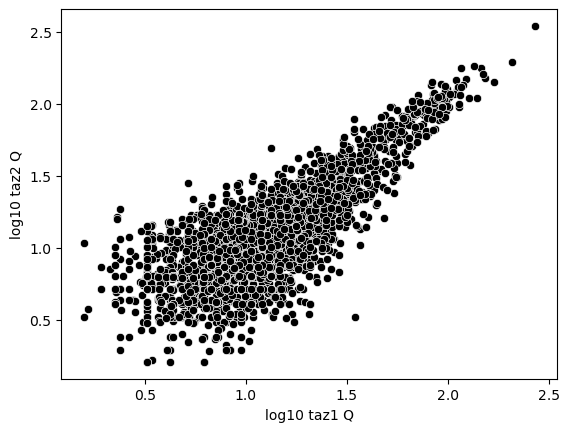

In [44]:
sns.scatterplot(x=np.log10(merged_peaks['taz1_q']),
                y=np.log10(merged_peaks['taz2_q']),
                c='k'
               )
plt.xlabel('log10 taz1 Q')
plt.ylabel('log10 taz2 Q')

What you should be able to see is a plot that begins to fan out as the value for the rank increases (so overall less significant peak), suggesting that those peaks identified in either set that do not have a high -log10(qvalue) may not be very reproducible. So in our more focused analysis, we will want to avoid those peaks and just look into those that consistently rank high (rank values closer to 1).

<h2>Exercise #8: Plot significance of two replicates against one another</h2>

We can also do the same for the -log10(qvalue) of our overlapping peaks.

Text(0, 0.5, 'taz2 rank')

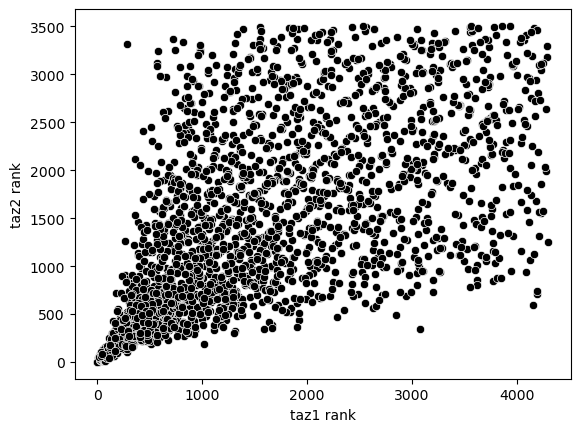

In [45]:
sns.scatterplot(x=merged_peaks['taz1_rank'],
                y=merged_peaks['taz2_rank'],
                c='k'
               )
plt.xlabel('taz1 rank')
plt.ylabel('taz2 rank')

To visually increase the spread of the lower significance samples, we can log transform the -log10(qvalue) using <code>np.log10()</code> when we plot each data point.

Alternatively, you can change the X- and Y-axes to log scale.

Again, we can see that peaks that are highly significant in one replicate are likely to also be similarly significant in the second replicate, which suggest that they are more consistent between replicates.

<h2>Exercise #9: Narrow down peaks to consistently high ranked peaks</h2>

We will focus our motif discovery to just those peaks that are consistently high ranked in both replicates. Although we don't have a specific IDR threshold value, we can qualitatively assess where the data seems to be most consistent, which appears to be for those peaks with a rank value of 500 or less in both replicates.

Now, see if you can make use of conditional statements to create a new DataFrame consisting of just the peaks that have a rank value of less than 500 for both replicates.

In [46]:
peaks_for_motifs = merged_peaks.loc[(merged_peaks['taz1_rank'] < 500) & (merged_peaks['taz2_rank'] < 500)]

Let's take a look at the first five rows of our focused dataset:

In [47]:
peaks_for_motifs.head().style

,name,chr,start,end,strand,Stat,Parent files,Total subpeaks,taz_1,taz_2,taz1_q,taz2_q,taz1_rank,taz2_rank
10,Merged-chr20-36746213-2,chr20,36746151,36746275,+,0.000000,/home/jovyan/MCB201B_F2024/Week_7/macs2/10M_taz_1_peaks.narrowPeak|/home/jovyan/MCB201B_F2024/Week_7/macs2/10M_taz_2_peaks.narrowPeak,2,10M_taz_1_peak_2416,10M_taz_2_peak_1975,33.078600,27.652600,302.000000,352.000000
23,Merged-chr20-49157672-2,chr20,49157609,49157736,+,0.000000,/home/jovyan/MCB201B_F2024/Week_7/macs2/10M_taz_1_peaks.narrowPeak|/home/jovyan/MCB201B_F2024/Week_7/macs2/10M_taz_2_peaks.narrowPeak,2,10M_taz_1_peak_2440,10M_taz_2_peak_1994,61.163800,44.897800,129.000000,204.000000
42,Merged-chr21-17936309-2,chr21,17936250,17936368,+,0.000000,/home/jovyan/MCB201B_F2024/Week_7/macs2/10M_taz_1_peaks.narrowPeak|/home/jovyan/MCB201B_F2024/Week_7/macs2/10M_taz_2_peaks.narrowPeak,2,10M_taz_1_peak_2478,10M_taz_2_peak_2024,38.999500,41.374900,244.000000,229.000000
55,Merged-chr1-55895008-2,chr1,55894953,55895063,+,0.000000,/home/jovyan/MCB201B_F2024/Week_7/macs2/10M_taz_1_peaks.narrowPeak|/home/jovyan/MCB201B_F2024/Week_7/macs2/10M_taz_2_peaks.narrowPeak,2,10M_taz_1_peak_104,10M_taz_2_peak_91,45.075800,33.987800,192.000000,282.000000
57,Merged-chr1-56192840-2,chr1,56192764,56192917,+,0.000000,/home/jovyan/MCB201B_F2024/Week_7/macs2/10M_taz_1_peaks.narrowPeak|/home/jovyan/MCB201B_F2024/Week_7/macs2/10M_taz_2_peaks.narrowPeak,2,10M_taz_1_peak_107,10M_taz_2_peak_93,25.405000,34.519200,432.000000,278.000000


And let's take a look at these data points with respect to the peaks that didn't make our cutoff.

Text(0, 0.5, 'taz2 rank')

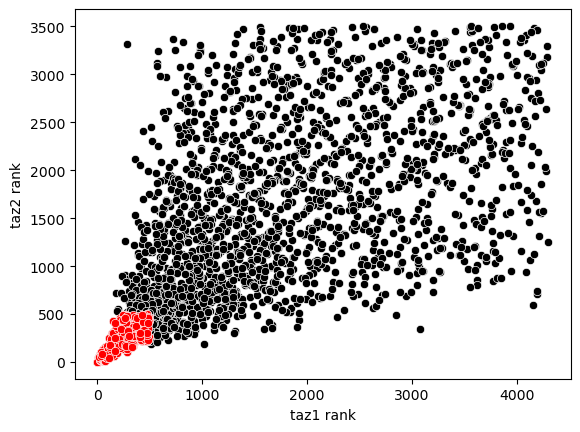

In [50]:
sns.scatterplot(x=merged_peaks['taz1_rank'],
                y=merged_peaks['taz2_rank'],
                c='k'
               )

sns.scatterplot(x=peaks_for_motifs['taz1_rank'],
                y=peaks_for_motifs['taz2_rank'],
                c='r'
               )
plt.xlabel('taz1 rank')
plt.ylabel('taz2 rank')

<h2>Exercise #10: Export your top concordant peaks for motif discovery</h2>

Now that we have a separate DataFrame that just has the focused peaks that we are interested in, we can export it into a new .narrowPeak file that we will supply to HOMER for motif analysis.

```
peaks_for_motifs.to_csv('top_concordant_peaks.narrowPeak',
                        header=False,
                        index=False,
                        sep='\t'
                       )
```

We'll want to export it without any extraneous things, so we'll specify that we don't want to export the headers or indices along with our data, and we'll also specify that our values will be separated by a tab.

In [51]:
peaks_for_motifs.to_csv('top_concordant_peaks.narrowPeak',
                        header=False,
                        index=False,
                        sep='\t'
                       )

You should now see that this DataFrame has been exported into this week's directory as a .narrowPeak file.

<h1 style="font-size: 40px; margin-bottom: 0px;">Motif Discovery</h1>

<hr style="margin-left: 0px; border: 0.25px solid; border-color: #000000; width: 400px;"></hr>

Here, we'll make use of the core function of HOMER, which is to identify motifs. To do this, we'll need to go back to Terminal to run the <code>findMotifsGenome.pl</code> program. <a href="http://homer.ucsd.edu/homer/ngs/peakMotifs.html" rel="noopener noreferrer" target="_blank"><u>Documentation for <code>findMotifsGenome.pl</code> is here.</u></a>

If we look into the documentation, we can see that the basic command line structure to use this code is:

<pre style="width: 600px; margin-top: 15px; margin-bottom: 15px; color: #000000; background-color: #EEEEEE; border: 1px solid; border-color: #AAAAAA; padding: 10px; border-radius: 15px; font-size: 12px;">findMotifsGenome.pl &lt;peak file&gt; &lt;genome version&gt; &lt;output directory&gt; -size &#35; &lbrack;options&rbrack;</pre>

So to run the findMotifsGenome program, we will supply it with our .narrowPeak file containing our focused list of overlapping peaks, the genome version, an output directory, a fragment size, and any additional options.

<h3>Create <code>motif</code> directory and enter it</h3>

<pre style="width: 450px; margin-top: 15px; margin-bottom: 15px; color: #000000; background-color: #EEEEEE; border: 1px solid; border-color: #AAAAAA; padding: 10px; border-radius: 15px; font-size: 12px;">mkdir motif</pre>

Make sure you make the new directory in this week's folder.

<pre style="width: 450px; margin-top: 15px; margin-bottom: 15px; color: #000000; background-color: #EEEEEE; border: 1px solid; border-color: #AAAAAA; padding: 10px; border-radius: 15px; font-size: 12px;">cd motif</pre>

<hr style="border: 1px solid; border-color: #BBBBBB;"></hr>

<h3>Run motif discovery program</h3>

<pre style="width: 450px; margin-top: 15px; margin-bottom: 15px; color: #000000; background-color: #EEEEEE; border: 1px solid; border-color: #AAAAAA; padding: 10px; border-radius: 15px; font-size: 12px;">findMotifsGenome.pl \
~/MCB201B_F2024/Week_8/top_concordant_peaks.narrowPeak \
hg19 \
./ \
-size 50 \
-S 5</pre>

<strong>Let's break down the code:</strong>

<code>findMotifsGenome.pl</code>

We call up the findMotifsGenome program.

<hr style="border: 1px solid; border-color: #AAAAAA;"></hr>

<code>~/MCB201B_F2024/Week_8/top_concordant_peaks.narrowPeak</code>

We provide it with our .narrowPeak file containing just our focused set of overlapping peaks.

<hr style="border: 1px solid; border-color: #AAAAAA;"></hr>

<code>hg19</code>

We indicate the genome version that it will use to pull sequences and find motifs. Recall that when we first set up HOMER, we preparsed the genome for 50bp fragments, and now we will be using that preparsed genome for motif discovery.

<hr style="border: 1px solid; border-color: #AAAAAA;"></hr>

<code>./</code>

We indicate the output directory as our current working directory.

<hr style="border: 1px solid; border-color: #AAAAAA;"></hr>

<code>-size 50</code>

We indicate the fragment size around the peak center where we want it to look for motifs. Here, it will look for motifs in the region &pm;50bp from the peak center.

<hr style="border: 1px solid; border-color: #AAAAAA;"></hr>

<code>-S 5</code>

This option specifies how many <i>de novo</i> motifs we want it to look for. The default option is 25, which is a lot. To keep the runtime down, we'll have it look for just 5 <i>de novo</i> motifs

<h2>Take a look at the identified motifs</h2>

Let's go ahead and take a look at the HTML output files to see what motifs we have identified within our peaks.

<h1 style="font-size: 40px; margin-bottom: 0px;">Visualize motif distributions</h1>

<hr style="margin-left: 0px; border: 0.25px solid; border-color: #000000; width: 600px;"></hr>

Now let's take a look at all the distribution of all our various TEAD motifs just to get an idea of where TEAD might be binding and how that compares to the center of our peaks, which should theoretically map to where TEAD is binding.

To do this, we'll make use of annotatePeaks' histogram mode, but we'll provide it with our TEAD motifs that we've found through our analysis. What annotatePeaks will do is go through our focused set of peaks and determine the distribution of our TEAD motifs around the center of all the peaks.

<h3>Change to <code>annotation</code> directory</h3>

If you're currently in the <code>motif</code> directory, you can make use of <code>../annotation</code> to change to the parent directory and go directly to the annotation folder.

<pre style="width: 450px; margin-top: 15px; margin-bottom: 15px; color: #000000; background-color: #EEEEEE; border: 1px solid; border-color: #AAAAAA; padding: 10px; border-radius: 15px; font-size: 12px;">cd ../annotation</pre>

<hr style="border: 1px solid; border-color: #BBBBBB;"></hr>

<h3>Obtain motif distributions around peak</h3>

Note that the files that you will provide may differ since each time HOMER runs, the results may change slightly. So my example may be different than what you see in your motif discovery output.

<pre style="width: 450px; margin-top: 15px; margin-bottom: 15px; color: #000000; background-color: #EEEEEE; border: 1px solid; border-color: #AAAAAA; padding: 10px; border-radius: 15px; font-size: 12px;">annotatePeaks.pl \
~/MCB201B_F2024/Week_8/top_concordant_peaks.narrowPeak \
hg19 \
-m ../motif/knownResults/known1.motif \
../motif/knownResults/known2.motif \
../motif/knownResults/known3.motif \
../motif/knownResults/known4.motif \
../motif/knownResults/known5.motif \
-size 2000 \
-hist 20 \
> motif_distribution.txt</pre>

<strong>Let's break down the code:</strong>

<code>annotatePeaks.pl</code>

This calls up the annotatePeaks program.

<hr style="border: 1px solid; border-color: #AAAAAA;"></hr>

<code>~/MCB201B_F2024/Week_8/top_concordant_peaks.narrowPeak</code>

This provides HOMER with our focused set of overlapping peaks.

<hr style="border: 1px solid; border-color: #AAAAAA;"></hr>

<code>hg19</code>

We specify the genome version.

<hr style="border: 1px solid; border-color: #AAAAAA;"></hr>

<code>-m</code>

This tells the program that we want it to do an analysis of a specific motif or set of motifs. In our case, we are providing it with motifs that we want it to use to determine their distributions within our focused set of peaks.

<hr style="border: 1px solid; border-color: #AAAAAA;"></hr>

<code>&lt;.motif files&gt;</code>

We provide the motif file(s) that we want the annotatePeaks program to use. We can supply it with a single motif file or more than one. In either case, the output will be a single file that contains information for each motif we provide it. Each motif will have 3 columns of data: one for total counts, one for (+) counts, and one for (-) counts.

<hr style="border: 1px solid; border-color: #AAAAAA;"></hr>

<code>-size 2000</code>

We specify the size of the region of interest that we're interested in looking at motif distributions. With a size set to 2000, we will be looking at a region &pm;1000bp centered on our peaks.

<hr style="border: 1px solid; border-color: #AAAAAA;"></hr>

<code>-hist 20</code>

We invoke the histogram mode of annotatePeaks and provide it with the bin size that it will use to determine the distribution of motifs in our specified region.

<hr style="border: 1px solid; border-color: #AAAAAA;"></hr>

<code>-hist 20</code>&gt; motif_distribution.txt</code>

We redirect the output to a file called <code>motif_distribution.txt</code> that we can then import into this Python notebook to plot.

<h2>Exercise #11: Plot the motif distributions as a lineplot together on the same plot</h2>

See if you can plot the motif distributions of your TEAD motifs that you analyzed with HOMER.

First, you'll want to import the file using the same method that we've been using:

In [3]:
motif_distribution = pd.read_csv('~/MCB201B_F2024/Week_8/annotation/motif_distribution.txt',
                                 delimiter='\t'
                                )

Check to make sure that it imported okay:

In [4]:
motif_distribution.head().style

,Distance from Center (cmd=annotatePeaks.pl /home/jovyan/MCB201B_F2024/Week_8/top_concordant_peaks.narrowPeak hg19 -m ../motif/knownResults/known1.motif ../motif/knownResults/known2.motif ../motif/knownResults/known3.motif ../motif/knownResults/known4.motif ../motif/knownResults/known5.motif -size 2000 -hist 20),TEAD4(TEA)/Tropoblast-Tead4-ChIP-Seq(GSE37350)/Homer total sites,TEAD4(TEA)/Tropoblast-Tead4-ChIP-Seq(GSE37350)/Homer + sites,TEAD4(TEA)/Tropoblast-Tead4-ChIP-Seq(GSE37350)/Homer - sites,TEAD2(TEA)/Py2T-Tead2-ChIP-Seq(GSE55709)/Homer total sites,TEAD2(TEA)/Py2T-Tead2-ChIP-Seq(GSE55709)/Homer + sites,TEAD2(TEA)/Py2T-Tead2-ChIP-Seq(GSE55709)/Homer - sites,TEAD3(TEA)/HepG2-TEAD3-ChIP-Seq(Encode)/Homer total sites,TEAD3(TEA)/HepG2-TEAD3-ChIP-Seq(Encode)/Homer + sites,TEAD3(TEA)/HepG2-TEAD3-ChIP-Seq(Encode)/Homer - sites,TEAD1(TEAD)/HepG2-TEAD1-ChIP-Seq(Encode)/Homer total sites,TEAD1(TEAD)/HepG2-TEAD1-ChIP-Seq(Encode)/Homer + sites,TEAD1(TEAD)/HepG2-TEAD1-ChIP-Seq(Encode)/Homer - sites,TEAD(TEA)/Fibroblast-PU.1-ChIP-Seq(Unpublished)/Homer total sites,TEAD(TEA)/Fibroblast-PU.1-ChIP-Seq(Unpublished)/Homer + sites,TEAD(TEA)/Fibroblast-PU.1-ChIP-Seq(Unpublished)/Homer - sites,A frequency,C frequency,G frequency,T frequency
0,-1000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000137,0.000000,0.000000,0.000137,0.000000,0.000000,0.000000,0.000000,0.260548,0.235068,0.249041,0.255342
1,-980,0.000820,0.000137,0.000546,0.000410,0.000137,0.000273,0.001093,0.000820,0.000137,0.000956,0.000683,0.000000,0.000683,0.000137,0.000410,0.261233,0.241096,0.243562,0.254110
2,-960,0.000273,0.000000,0.000410,0.000410,0.000000,0.000410,0.001093,0.000683,0.000410,0.000410,0.000546,0.000137,0.000410,0.000000,0.000410,0.249863,0.241644,0.237671,0.270822
3,-940,0.000273,0.000000,0.000273,0.000000,0.000000,0.000000,0.000273,0.000137,0.000137,0.000683,0.000273,0.000273,0.000273,0.000000,0.000410,0.262877,0.229178,0.250959,0.256986
4,-920,0.000546,0.000273,0.000137,0.000410,0.000137,0.000137,0.000683,0.000546,0.000273,0.000820,0.000410,0.000410,0.000410,0.000137,0.000137,0.259178,0.237945,0.239589,0.263288


The column headers are pretty long, but for this, we'll just make use of <code>pd.DataFrame.iloc</code> and slice notation to pull columns to plot.

See if you can set up a for loop to plot all your lineplots onto the same plot.

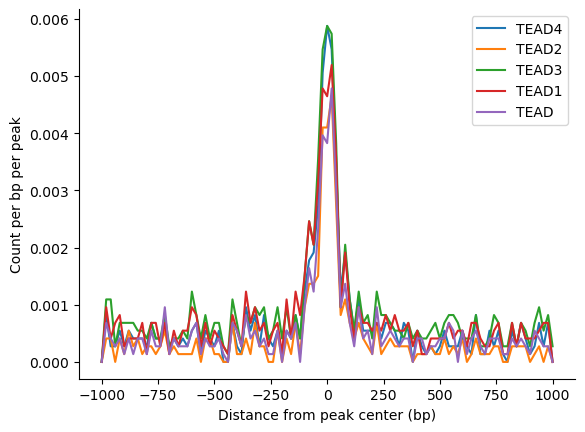

In [7]:
fig, ax = plt.subplots()

col = [1, 4, 7, 10 , 13]
labels = ['TEAD4', 'TEAD2', 'TEAD3', 'TEAD1', 'TEAD']

for a, b in zip(col, labels):
    sns.lineplot(x=motif_distribution.iloc[:,0],
                 y=motif_distribution.iloc[:,a],
                 label=b
                )

plt.xlabel('Distance from peak center (bp)')
plt.ylabel('Count per bp per peak')
sns.despine()

<h1 style="font-size: 40px; margin-bottom: 0px;">References</h1>

<hr style="margin-left: 0px; border: 0.25px solid; border-color: #000000; width: 300px;"></hr>

<a href="https://www.nature.com/articles/ncb3216" rel="noopener noreferrer" target="_blank"><u>Zanconato et al 2015 Nat Cell Biol:</u></a> Genome-wide association between YAP/TAZ/TEAD and AP-1 at enhancers drives oncogenic growth

<a href="https://genome.cshlp.org/content/22/9/1813" rel="noopener noreferrer" target="_blank"><u>Landt et al 2012 Genome Res:</u></a> ChIP-seq guidelines and practices of the ENCODE and modENCODE consortia

<a href="https://projecteuclid.org/journals/annals-of-applied-statistics/volume-5/issue-3/Measuring-reproducibility-of-high-throughput-experiments/10.1214/11-AOAS466.full" rel="noopener noreferrer" target="_blank"><u>Li et al 2011 Ann Appl Stat:</u></a> Measuring reproducibility of high-throughput experiments